In [1]:
import plenoptic as po
from plenoptic.tools import to_numpy
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72
import numpy as np
import os
import glob
import torchvision.transforms as transforms
from PIL import Image



%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
po.tools.set_seed(1)

# import select color images
path_to_unsplash = '../../../ceph/Datasets/select_color_textures_unsplash'
# Step 1: Check if the path to the images exists
# You can specify the extensions of the images you want to load, e.g., *.jpg, *.png, etc.
image_files = glob.glob(os.path.join(path_to_unsplash, '*.jpg'))  # Assuming images are in .jpg format
image_files.extend(glob.glob(os.path.join(path_to_unsplash, '*.png')))  # Include .png format as well

# Step 2: Load the images
images = []
for image_file in image_files:
    try:
        img = Image.open(image_file)
        images.append(img)
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")
#po.imshow(po.tools.load_images(path_to_unsplash, as_gray=False), as_rgb=True)


In [3]:
# transform the images to tensors and then resize them to 256x256
#images = [torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255.0 for img in images]
# Define a sequence of transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # resize to 256x256
    transforms.ToTensor(),  # Convert to tensor
])

# Apply the transformations
img_tensor_ls = []
for img in images:
    img_tensor_ls.append(transform(img))

img_tensor = torch.stack(img_tensor_ls, dim=0) # stack the images along the batch dimension
# send images to GPU, if available
img_tensor = img_tensor.to(DEVICE)


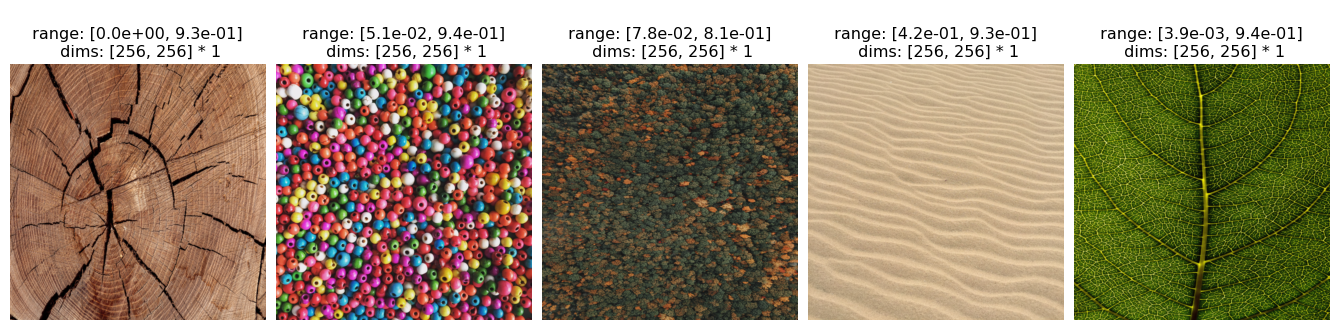

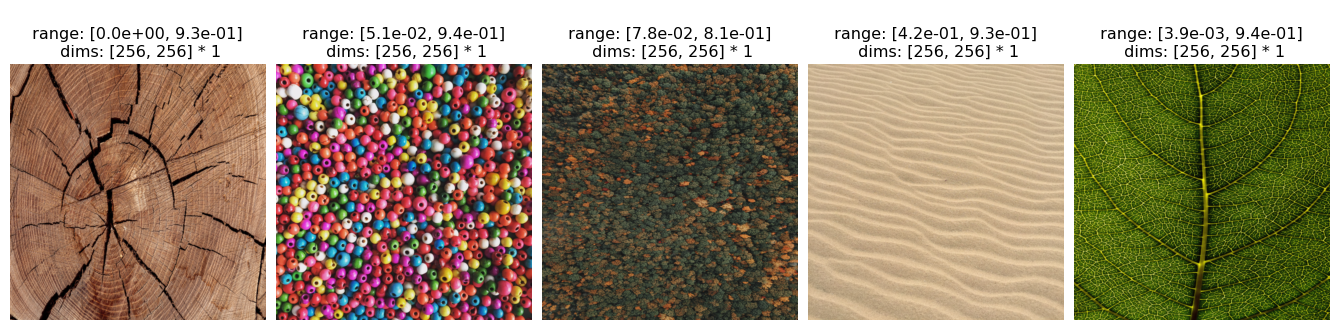

In [4]:
po.imshow(img_tensor, as_rgb=True)  

## Model

In [5]:
import torchvision.models as models


# Load the pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)

# Remove the final fully connected layer
modules = list(resnet50.children())[:-1]
resnet50_embedding = torch.nn.Sequential(*modules).to(DEVICE)
po.tools.remove_grad(resnet50_embedding)
# Set the model to evaluation mode
resnet50_embedding.eval()

# Check the modified model
print(resnet50_embedding)


/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /dev/shm/.cache-hdettki/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [6]:
resnet50_embedding(img_tensor).shape

torch.Size([5, 2048, 1, 1])

In [7]:
# let's get the model representation of the images, output shape after flatten is (batch_size, 2048)
model_representation = resnet50_embedding(img_tensor).view(img_tensor.size(0), -1)

: 

## Let's generate some metamers

In [8]:
img = img_tensor[0].unsqueeze(0)
im_init = torch.rand_like(img) * .1 + img.mean()
#im_init = im_init.unsqueeze(0)
print(im_init.shape)
print(img.shape)
im_init_expand = im_init.expand(img_tensor.size(0), -1, -1, -1)

met = po.synth.Metamer(img_tensor, resnet50_embedding,initial_image=im_init_expand,loss_function=po.tools.optim.l2_norm)
opt = torch.optim.Adam([met.metamer], lr=.01, amsgrad=True)
met.synthesize(store_progress=True, max_iter=50000, optimizer=opt, stop_criterion=1e-100)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  0%|          | 0/50000 [00:00<?, ?it/s]

In [1]:
po.imshow(met.metamer, as_rgb=True)


NameError: name 'po' is not defined

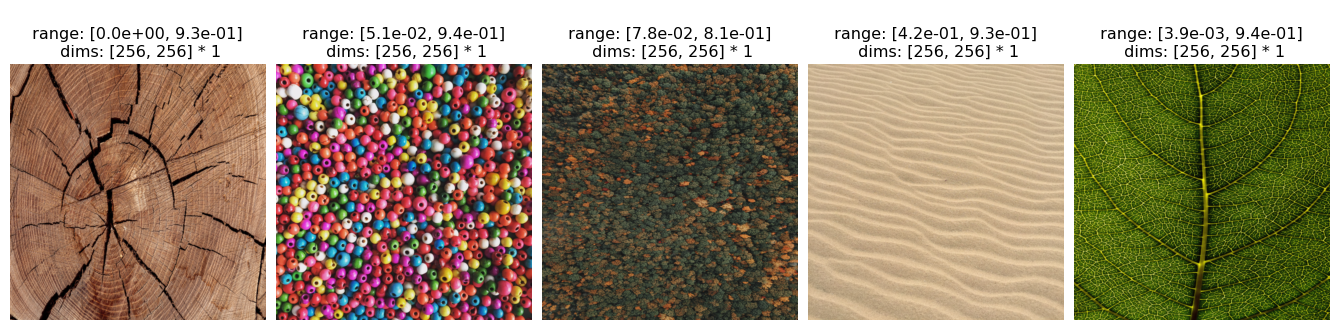

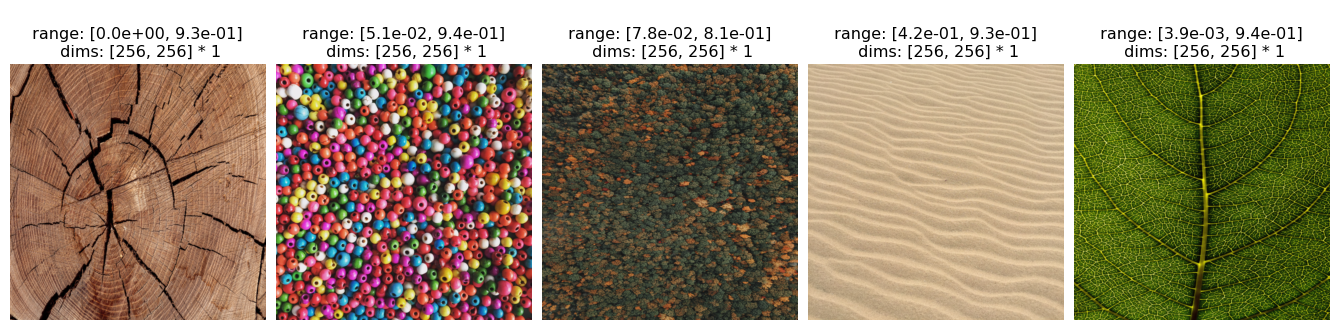

In [ ]:
po.imshow(met.image, as_rgb=True)

## Portilla-Simoncelli Model



In [ ]:
model = po.simul.PortillaSimoncelli(img.shape[-2:], n_orientations=4).to(DEVICE)
met = po.synth.MetamerCTF(img_tensor, model, initial_image=im_init_expand, loss_function=po.tools.optim.l2_norm)
met.synthesize(store_progress=True, max_iter=3000, stop_criterion=1e-100)

/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(
/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/validate.py:211: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn("Validating whether model can work with coarse-to-fine synthesis -- this can take a while!")


  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00052432576..0.9255148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01061269..1.000995].


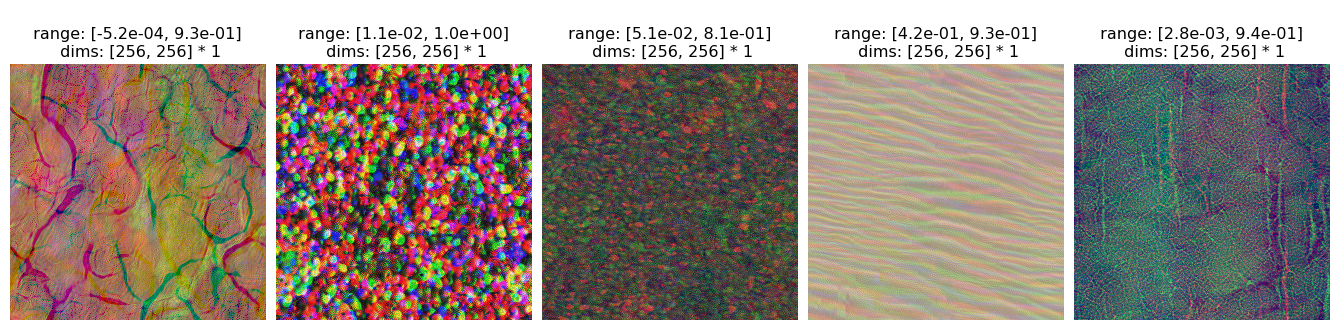

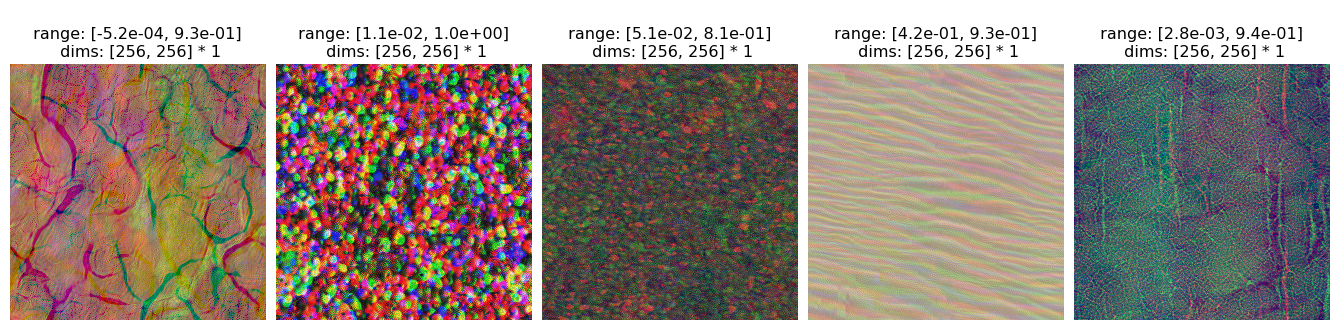

In [ ]:
po.imshow(met.metamer, as_rgb=True)